# Lead Scoring Model using XGBoost and SMOTE
This notebook builds a lead scoring model using XGBoost and applies SMOTE to balance class labels.


Import necessary libraries

In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


## Load the Labeled Dataset


In [2]:
df = pd.read_csv("labeled_mock_leads_dataset_2000.csv")
df.head()



,Company,Website,Industry,Product/Service Category,Business Type,Employees Count,Revenue,Year Founded,BBB Rating,Street,...,Owner's Last Name,Owner's Title,Owner's LinkedIn,Owner's Phone Number,Owner's Email,Source,Created Date,Updated,Actions,Lead Quality
0,"Hays, Carlson and Glover",http://www.perry.biz/,Healthcare,Healthcare Solutions,B2B,15,6.41,2007,B,7879 Joshua Garden Apt. 764,...,Melton,Owner,https://www.linkedin.com/in/recently-create,(713)263-2970x7750,pauldavis@example.net,Mock Generator,2025-07-03,2025-06-30,NaN,Medium
1,Cannon-Barnes,https://www.rice.com/,Software,Software Solutions,B2B2C,282,7.42,1995,A+,118 Joseph Hill,...,Barrett,Founder,https://www.linkedin.com/in/series-prevent-baby,+1-455-566-7271x22274,cory95@example.org,Mock Generator,2025-01-22,2025-07-28,NaN,Low
2,Peterson-Maldonado,https://wyatt.com/,Education,Education Solutions,B2B2C,311,2.36,1991,B,705 John Glen,...,Gaines,Co-Founder,https://www.linkedin.com/in/pretty-why,452.699.8918x51207,jhall@example.net,Mock Generator,2025-01-06,2025-07-29,NaN,Medium
3,Rivera-Parks,http://davis-crawford.info/,Software,Software Solutions,B2C,232,4.22,2007,B,69339 Moss Loop Apt. 627,...,Roberts,Founder,https://www.linkedin.com/in/them-really,001-406-515-9022x07798,sonyabrown@example.org,Mock Generator,2025-07-20,2025-03-12,NaN,Low
4,"Hernandez, Hawkins and Rice",http://kelley-sanders.com/,Retail,Retail Solutions,B2B,177,7.00,2007,A+,6639 Lewis Crossing,...,Johnson,Managing Director,https://www.linkedin.com/in/loss-amount,(916)568-3083x7532,vancewanda@example.org,Mock Generator,2025-01-01,2025-04-13,NaN,Low


## Visualize Lead Quality Distribution


To understand the distribution of the labels, we visualize it below.

C:\Users\Zaki\AppData\Local\Temp\ipykernel_36464\1631786353.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lead Quality', y='Count', data=label_counts, palette='viridis')


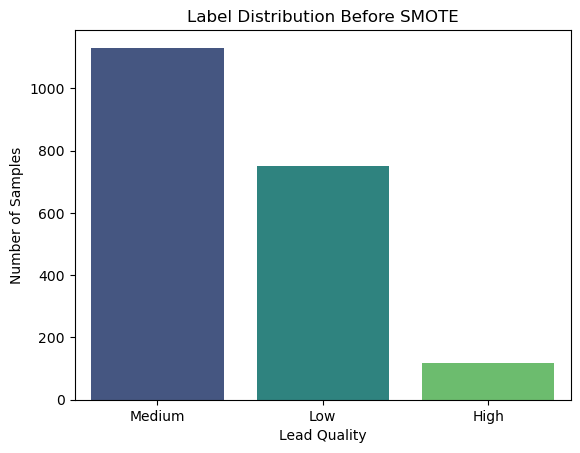

In [3]:
label_counts = df['Lead Quality'].value_counts().reset_index()
label_counts.columns = ['Lead Quality', 'Count']
sns.barplot(x='Lead Quality', y='Count', data=label_counts, palette='viridis')
plt.title("Label Distribution Before SMOTE")
plt.ylabel("Number of Samples")
plt.xlabel("Lead Quality")
plt.show()


## Feature Engineering and Label Encoding


In [4]:
features = ['Business Type', 'Revenue', 'Employees Count', 'Year Founded',
            "Owner's Title", 'BBB Rating']
target = 'Lead Quality'

X = df[features]
y = df[target]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


## Split Dataset into Train and Test Sets


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


## Preprocessing with ColumnTransformer


In [6]:
categorical_features = ['Business Type', "Owner's Title", 'BBB Rating']
numeric_features = ['Revenue', 'Employees Count', 'Year Founded']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


## Apply SMOTE to Balance Classes


In [7]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)



## Train the XGBoost Classifier


In [8]:
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train_resampled, y_train_resampled)


c:\Users\Zaki\anaconda3\envs\caprae_project\lib\site-packages\xgboost\training.py:183: UserWarning: [09:20:10] WARNING: D:\bld\xgboost-split_1754001889079\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluate the Model


In [9]:
y_pred = model.predict(X_test_processed)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))


              precision    recall  f1-score   support

        High       0.95      0.75      0.84        24
         Low       0.97      0.95      0.96       150
      Medium       0.94      0.98      0.96       226

    accuracy                           0.95       400
   macro avg       0.95      0.89      0.92       400
weighted avg       0.95      0.95      0.95       400



## Save the Model and Preprocessing Artifacts


In [10]:
joblib.dump(model, 'lead_scorer_smote.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']